In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
import random
from density_db import density_database
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import warnings

In [2]:
#get data
def get_data():
    rawData = density_database('density.db').selectAllErrorsWithParams('Redfield').fetchall()
    return pd.DataFrame(data=rawData, columns=['delta_e', 'J', 'lambda', 'gamma', 'T', 'error'])

In [3]:
#plot
def plot_error(data):
    data.loc[
        #(data['delta_e'] == 100.)
         (data['J'] == 100.)
        & (data['lambda'] == 10.)
        & (data['gamma'] == 10.)
        & (data['T'] == 300.)
    ].plot(kind="scatter", x="delta_e", y="error", logy=True)
    plt.ylim(10**-5,10**-2)
#plot_error(get_data())

In [4]:
#explore combinations
def correletions():
    tryData = get_data()
    tryData['gamma-lambda'] = tryData['gamma']*tryData['lambda']
    tryData['gamma-delta_e'] = tryData['gamma']*tryData['delta_e']
    tryData['gamma-J'] = tryData['gamma']*tryData['J']
    tryData['lambda-delta_e'] = tryData['lambda']*tryData['delta_e']
    tryData['lambda-J'] = tryData['lambda']*tryData['J']
    tryData['delta_e-J'] = tryData['delta_e']*tryData['J']
    corr_matrix = tryData.corr()
    return corr_matrix['error']

In [5]:
def prepare_train_and_test_sets(data):
    modifiedData = data.copy()
    modifiedData['delta_e'] = modifiedData['delta_e']/400
    modifiedData['J'] = modifiedData['J']/400
    modifiedData['lambda'] = modifiedData['lambda']/400
    modifiedData['gamma'] = modifiedData['gamma']/400
    modifiedData['T'] = modifiedData['T']/300
    modifiedData['gamma-lambda'] = modifiedData['gamma']*modifiedData['lambda']
    modifiedData['gamma-delta_e'] = modifiedData['gamma']*modifiedData['delta_e']
    modifiedData['gamma-J'] = modifiedData['gamma']*modifiedData['J']
    modifiedData['lambda-delta_e'] = modifiedData['lambda']*modifiedData['delta_e']
    modifiedData['lambda-J'] = modifiedData['lambda']*modifiedData['J']
    modifiedData['delta_e-J'] = modifiedData['delta_e']*modifiedData['J']
    modifiedData['error'] = np.log(modifiedData['error'])
    return modifiedData

In [6]:
train_set = prepare_train_and_test_sets(get_data())

In [7]:
def mspe(y, y_predicted):
    y = np.exp(y)
    y_predicted = np.exp(y_predicted)
    return 100 * np.sum(np.square((y - y_predicted)/y)) / len(y)

def mape(y, y_predicted):
    y = np.exp(y)
    y_predicted = np.exp(y_predicted)
    return 100 * np.sum(np.abs((y - y_predicted)/y)) / len(y)

def mae(y, y_predicted):
    y = np.exp(y)
    y_predicted = np.exp(y_predicted)
    return np.sum(np.abs(y - y_predicted)) / len(y)

def rmse(y, y_predicted):
    y = np.exp(y)
    y_predicted = np.exp(y_predicted)
    return np.sqrt(np.sum(np.square(y - y_predicted)) / len(y))

def visualiseError(data_labels, labels_predicted):
    sort = np.argsort(data_labels)
    plt.plot(range(len(data_labels)), [data_labels[i] for i in sort])
    plt.plot(range(len(labels_predicted)), [labels_predicted[i] for i in sort])
    plt.ylim(-10, 0)
    plt.show()

def trainMethod(methodFactory, train_set, argsForFit):
    data_labels = np.array(train_set["error"].copy())
    data_prepared = np.array(train_set.drop("error", axis=1))
    kfold = KFold(n_splits=3, shuffle=True, random_state=10)
    errors = [];
    errors_train = [];
    part_error = None;
    for train, test in kfold.split(data_prepared, data_labels):
        method = methodFactory()
        method.fit(data_prepared[train], data_labels[train], **argsForFit)
        labels_predicted_train = np.squeeze(method.predict(data_prepared[train]))
        labels_predicted = np.squeeze(method.predict(data_prepared[test]))
        #if len(errors) == 0:
        #    visualiseError(data_labels[test], labels_predicted)
        errors.append(rmse(data_labels[test], labels_predicted))
        errors_train.append(rmse(data_labels[train], labels_predicted_train))
    print('Test Error: %.2e' % (sum(errors)/len(errors)))
    print('Train Error: %.2e' % (sum(errors_train)/len(errors_train)))
    return (sum(errors)/len(errors), sum(errors_train)/len(errors_train))

In [8]:
def createLinearRegressor():
    return LinearRegression()

def createRandomForestRegressor():
    return RandomForestRegressor(n_estimators=50, max_leaf_nodes = 100, max_depth = 5)

def createSupportVectorMachinesRegressor():
    return SVR(kernel = 'rbf', gamma = 'scale', epsilon = 0.1, C = 1)

def createNearestNeighborsRegressor():
    return KNeighborsRegressor(n_neighbors=5, weights='uniform')

def createLinearLassoRegressor():
    return Lasso(alpha = 0.01)

def createLinearRidgeRegressor():
    return Ridge()

def createDecisionTreeRegressor():
    return DecisionTreeRegressor(max_leaf_nodes = 100, max_depth = 5)

def createGaussianProcessRegressor():
    kernel = DotProduct() + WhiteKernel()
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-9, random_state=1)

def createVotingRegressor():
    svr = createSupportVectorMachinesRegressor()
    for_reg = createRandomForestRegressor()
    k_neigh = createNearestNeighborsRegressor()
    linear = createLinearRegressor()
    return VotingRegressor([('a', svr), ('b', for_reg), ('c', k_neigh), ('d', linear)])

def createNeuralNetwork():
    method = keras.Sequential([
            keras.layers.Dense(11, activation = 'elu', input_shape=(11,)),
            keras.layers.Dense(11, activation = 'elu'),
            keras.layers.Dense(1)
        ])
    optimizer = optimizers.Adam(learning_rate=0.1)
    method.compile(optimizer=optimizer, loss='mean_squared_error')
    return method

In [9]:
allErrors = []
allLabels = ['Linear', 'Linear Lasso', 'Linear Ridge', 'Random Forest',
             'Decision Tree', 'K Nearest Neighbors', 'Support Vector Machines',
             'Voting Regressor', 'Neural Network']
allLabels = ['Tiesinė regresija', 'Laso regresija', 'Keteros regresija', 'Atsitiktinis miškas',
             'Sprendimo medis', 'K artimiausių kaimynų', 'Atraminių vektorių mašinos',
             'Balsavimo regresija', 'Neuroniniai tinklai']
print('Linear')
error = trainMethod(createLinearRegressor, train_set, {})
allErrors.append(error)
print()
print('Linear Lasso')
error = trainMethod(createLinearLassoRegressor, train_set, {})
allErrors.append(error)
print()
print('Linear Ridge')
error = trainMethod(createLinearRidgeRegressor, train_set, {})
allErrors.append(error)
print()
print('Random Forest')
error = trainMethod(createRandomForestRegressor, train_set, {})
allErrors.append(error)
print()
print('Decision Tree')
error = trainMethod(createDecisionTreeRegressor, train_set, {})
allErrors.append(error)
print()
print('K Nearest Neighbors')
error = trainMethod(createNearestNeighborsRegressor, train_set, {})
allErrors.append(error)
print()
print('Support Vector Machines')
error = trainMethod(createSupportVectorMachinesRegressor, train_set, {})
allErrors.append(error)
print()
print('Voting Regressor')
error = trainMethod(createVotingRegressor, train_set, {})
allErrors.append(error)
print()
#print('Gaussian Process')
#error = trainMethod(createGaussianProcessRegressor, train_set, {})
#allErrors.append(error)
#print()
print('Neural Network')
error = trainMethod(createNeuralNetwork, train_set, {'batch_size': 100, 'epochs': 200, 'validation_split': 0, 'verbose': 0})
allErrors.append(error)
fiveFeaturesErrors = allErrors;

Linear
Test Error: 1.06e-03
Train Error: 1.06e-03

Linear Lasso
Test Error: 9.98e-04
Train Error: 9.97e-04

Linear Ridge
Test Error: 1.05e-03
Train Error: 1.05e-03

Random Forest
Test Error: 7.29e-04
Train Error: 6.85e-04

Decision Tree
Test Error: 7.86e-04
Train Error: 7.50e-04

K Nearest Neighbors
Test Error: 7.56e-04
Train Error: 6.60e-04

Support Vector Machines
Test Error: 6.36e-04
Train Error: 5.88e-04

Voting Regressor
Test Error: 6.76e-04
Train Error: 6.36e-04

Neural Network
Test Error: 7.43e-04
Train Error: 6.85e-04


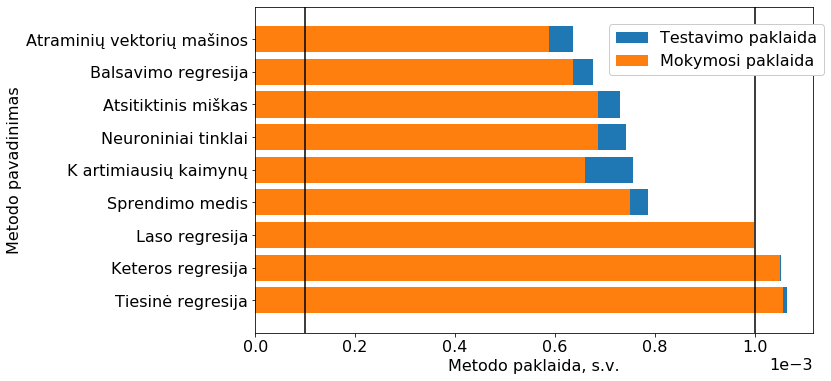

In [10]:
allErrors
testErrors = list(zip(*allErrors))[0]
trainErrors = list(zip(*allErrors))[1]
sort = list(reversed(np.argsort(testErrors)))
plt.figure(figsize=(10, 6))
plt.plot([10**-3, 10**-3], [-10, 15], c = 'k')
plt.plot([10**-4, 10**-4], [-10, 15], c = 'k')
a = plt.barh([allLabels[i] for i in sort], [testErrors[i] for i in sort])
b = plt.barh([allLabels[i] for i in sort], [trainErrors[i] for i in sort])
plt.legend([a, b], ['Testavimo paklaida', 'Mokymosi paklaida'], bbox_to_anchor=(0.62, 0, 0, 0.97), framealpha = 1, fontsize=16)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(-1, 9)
plt.xlabel('Metodo paklaida, s.v.', fontsize=16)
plt.ylabel('Metodo pavadinimas', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.gca().xaxis.get_offset_text().set_fontsize(16)
plt.savefig('grafikas.png', bbox_inches = 'tight', pad_inches = 0.5)

In [11]:
data = prepare_train_and_test_sets(get_data());
data_labels = np.exp(np.array(data["error"].copy()))
data_prepared = np.array(data.drop("error", axis=1))
smallIdx = data_labels < 5*10**-4
bigIdx = data_labels > 5*10**-4
data_labels[smallIdx] = 1
data_labels[bigIdx] = 0
X_train, X_test, y_train, y_test = train_test_split(data_prepared, data_labels, test_size=0.33, random_state=38)
#data_labels
clf = SVC(kernel = 'rbf', gamma = 'scale', C = 100)
clf.fit(X_train, y_train)
#print(clf.predict(X_test))
print(accuracy_score(y_test, clf.predict(X_test)))
print(precision_score(y_test, clf.predict(X_test)))
print(recall_score(y_test, clf.predict(X_test)))

0.9361702127659575
0.9433962264150944
0.847457627118644


In [12]:
print(get_data()['error'].mean()*1000)
print(get_data()['error'].std()*1000)
min(get_data()['error'])

1.3409412121817197
1.3992794100700945


2.9523591214442626e-06

In [13]:
#fiveTestErrors = np.array(list(zip(*fiveFeaturesErrors))[0])
#elevenTestErrors = np.array(list(zip(*elevenFeaturesErrors))[0])
#relErrors = 100*(fiveTestErrors - elevenTestErrors)/fiveTestErrors
#dict(zip(allLabels, relErrors))

In [14]:
import sklearn
sklearn.__version__

'0.22.1'